# ML_RFC

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

**Index**

1. [Import Libraries & Data](#Import_Libraries&Data)

2. [RFC not incl LDA](#RFC_not_incl_LDA)

  - Model RFC
  - Model RFC reducing imbalance data
  - Model RFC removing not important features
  
  
3. [RFC incl LDA](#RFC_incl_LDA)   

  - Model RFC reducing imbalance data
  - Model RFC removing not important features
  

4. [RFC Final Conclusion](#RFC_Final_Conclusion)

### Import_Libraries&Data

#### Import Libraries

In [82]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#### Import Data

In [51]:
churn_norm = pd.read_csv("Churn_Norm.csv")

In [52]:
churn_norm.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Int,Geography_Germany,Geography_Spain,Balance_Int
0,0.538,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1.0,1.0,0.0,0.0,0.0
1,0.516,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0,1.0,0.0,1.0,1.0
2,0.304,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1.0,1.0,0.0,0.0,1.0
3,0.698,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0.0,1.0,0.0,0.0,0.0
4,1.000,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0,1.0,0.0,1.0,1.0


In [53]:
# place target column at the end of the dataset
churn_norm= churn_norm[["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary","Gender_Int","Geography_Germany","Geography_Spain","Balance_Int","Exited"]]

# RFC_not_incl_LDA

## Model RFC 
Simple check of Random Forest Classification Model

#### Define X,y

In [87]:
# Define X (selects every row and every column except the last column)
X = churn_norm.iloc[:,:-1]

# Define target/labels  
y = churn_norm['Exited']

#### Split the data into training and testing sets

In [88]:
# random_state: will help us get the same results everytime we ran the code. should we use it?
# stratify: makes sure that the training and test datasets contain examples of each 
# class in the same proportions as in the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1, stratify=y)

In [89]:
# Count of each y class
y.value_counts()

0.0    7963
1.0    2037
Name: Exited, dtype: int64

In [90]:
y_test.value_counts()

0.0    796
1.0    204
Name: Exited, dtype: int64

The classes are imbalanced. We have approx. 80% of the variable in our class 0 and 20% of our variable in class 1. We'll have to take into account this fact when evaluating the Random Forest Classification, as most of the times, the model would score highly on accuracy, but it wouldn’t help us identify examples of the smaller class.

#### Model

In [91]:
RFC_model= RandomForestClassifier()

We use **GridSearch** to select the values for a model’s parameters that maximize the accuracy of the model. Grid Search does this by fitting every combination of parameters and selecting the best ones.

In [96]:
params= {
    "n_estimators":[100,300,500],
    # que las clases que me separas sea los mejor posible
    "criterion": ["gini", "entropy"],
    # lo vemos con tree.get_depth() para decidir las combinaciones
    "max_depth": [5, 10]
    
}

RFC_model_sel= GridSearchCV(RFC_model, params)
RFC_model_sel.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'n_estimators': [100, 300, 500]})

In [98]:
RFC_model_sel.best_estimator_

RandomForestClassifier(max_depth=10)

In [99]:
RFC_model_sel.best_estimator_.score(X_test, y_test)

0.863

In [100]:
RFC_model_sel.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

#### Define model with its best params

In [110]:
RFC_model=RandomForestClassifier(random_state=42,  
                            n_estimators= 100, 
                            max_depth=10, 
                            criterion='gini')
RFC_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

**Evaluation**

In [111]:
RFC_y_pred = RFC_model.predict(X_test)
RFC_score = round(RFC_model.score(X_train, y_train) * 100, 2)
print(round(RFC_score,2,), "%")

89.71 %


In [112]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, RFC_y_pred))

Accuracy: 0.861


Appearenly, we have a pretty good **accuracy**. But, in thiss case, it is not a great measure of classifier performance, because as seen before, the classes are imbalanced.

Therefore we will proceed on checking the **confusion matrix**, which will help us to see how many of a classifier’s predictions were correct and when incorrect.


In [113]:
print(confusion_matrix(y_test, RFC_y_pred))

[[773  23]
 [116  88]]


True+: 773  False-: 23

False+: 114 True-: 90

We can see that the RF classifier struggled at predicting the clients that didn't churned/exited the bank.

To get even more deeply into model performance and see the what kind of errors the model made, we would do a **Classification report** and check precision, recall and F1 score:

In [115]:
print(classification_report(y_test, RFC_y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       796
         1.0       0.79      0.43      0.56       204

    accuracy                           0.86      1000
   macro avg       0.83      0.70      0.74      1000
weighted avg       0.85      0.86      0.84      1000



We can see that:


No churn / Not Exited clients (0)

- **Precision** is quite good: the model was careful enough to avoid labeling clients “Not Exited” that aren’t "Not Exited".  
- **Recall** is high: the classifier is not missing a bunch of "Not Exited"
- **F1 Score** reflects this balance.


Churn / Exit client (1)

- **Precision** is quite low: the model was not careful enought to avoid labeling clients “Exited” that aren’t "Exited". 
- **Recall** is a very low: the classifier is missing a lot of "Exited" because it is being too careful
- **F1 Score** reflects this big imbalance.





Last but not list, we evaluate our training and test data with the **cross validation score**.

This approach involves randomly dividing the set of observations into k groups, or folds, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining k − 1 folds. — source: Book:An Introduction to Statistical Learning, 2013.

It is also a preventative measure against overfitting

In [117]:
# by default, as our y is binary, it is using (Stratified)KFold, which means that the folds are
# made by preserving the percentage of samples for each class.
# Nevertheless we specify it.

scores = cross_val_score(RFC_model, X_train, y_train, cv=StratifiedKFold(), scoring = "accuracy")

In [118]:
print("Scores:", scores, "\n")
print("Mean:", scores.mean(), "\n")
print("Standard Deviation:", scores.std(), "\n")

Scores: [0.86555556 0.86944444 0.85944444 0.86777778 0.86111111] 

Mean: 0.8646666666666665 

Standard Deviation: 0.003826483412827225 



We see our score is as realistic as before. Our model has a average accuracy of 86% with a standard deviation of 0.05 %. The standard deviation shows us, how precise the estimates are. 

The accuracy is still "good" , but we will try to increase it's performance in the following step by reducing imbalance data & removing less important features from our dataset.

## Model RFC reducing imbalance data

Before deciding the right model to do over-samping and/or under-sampling, we visualized the data

- Visualizing original data 

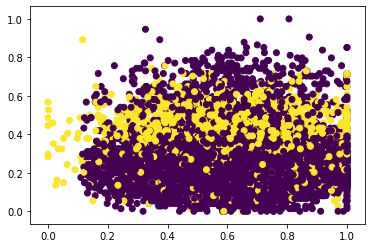

In [66]:
# original data
plt.scatter(X.values[:,0],X.values[:,1], c=y);

- Visualizing data with TSNE

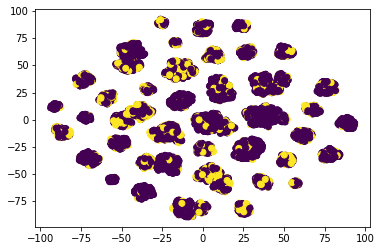

In [67]:
X_red = TSNE().fit_transform(X)
plt.scatter(X_red[:,0],X_red[:,1], c=y);

- Visualizing data with PCA

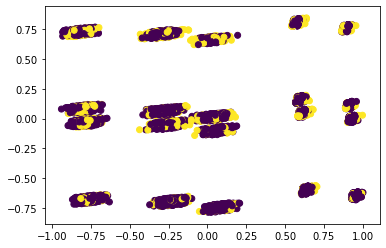

In [70]:
x_pcs = PCA().fit_transform(X)
plt.scatter(x_pcs[:,0], x_pcs[:,1], c=y);

Let's now use a combination of **SMOTE and Tomek Links** to balance our data.

- SMOTE is an oversampling method that synthesizes new plausible examples in the majority class.

- Tomek Links is an undersampling  method that remove unwanted overlap between classes where majority class links are removed until all minimally distanced nearest neighbor pairs are of the same class. 


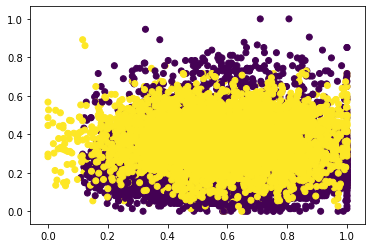

In [72]:
stomek = SMOTETomek ()
X_stomek, y_stomek = stomek.fit_sample(X_train, y_train)
plt.scatter(X_stomek.values[:,0],X_stomek.values[:,1], c=y_stomek);

We use TSNE to visualize few variables after trying to balance our data

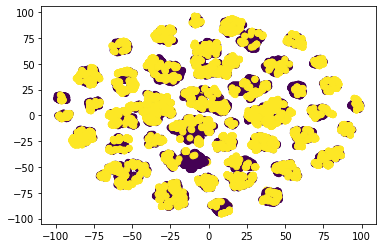

In [73]:
X_red = TSNE().fit_transform(X_stomek)
plt.scatter(X_red[:,0],X_red[:,1], c=y_stomek);

We use TSNE to visualize few variables after trying to balance our data

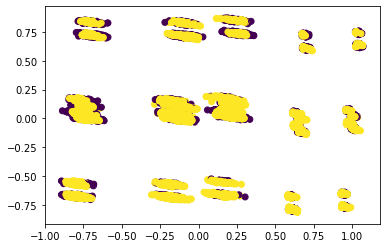

In [76]:
X_pcs = PCA().fit_transform(X_stomek)
plt.scatter(X_pcs[:,0], X_pcs[:,1], c=y_stomek);

Next, we check if the model returns better **results after reducing the imbalance data**:

In [77]:
RFC_model= RandomForestClassifier()
RFC_model.fit(X_stomek, y_stomek)
RFC_y_pred = RFC_model.predict(X_test)

RFC_score = round(RFC_model.score(X_stomek, y_stomek) * 100, 2)
print(round(RFC_score,2,), "%")

100.0 %


In [78]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, RFC_y_pred))

Accuracy: 0.823


**Evaluation**

Appearenly, we have a lower **accuracy**. So will proceed on checking the **confusion matrix**, which will help us to see how many of a classifier’s predictions were correct and when incorrect.

In [31]:
print(classification_report(y_test, RFC_y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       796
         1.0       0.56      0.57      0.56       204

    accuracy                           0.82      1000
   macro avg       0.72      0.73      0.73      1000
weighted avg       0.82      0.82      0.82      1000



We see that the recall is a bit more balance between churn and not churn, As before we had recall of: 
- 0.0-> 0.97
- 0.1-> 0.44

We are interested that Churn (0.1) is higher.

Belowe we evaluate our training and test data with the **cross validation score**.

In [33]:
scores = cross_val_score(RFC_model, X_stomek, y_stomek, cv=StratifiedKFold(), scoring = "accuracy")

In [34]:
print("Scores:", scores, "\n")
print("Mean:", scores.mean(), "\n")
print("Standard Deviation:", scores.std(), "\n")

Scores: [0.83546553 0.89765458 0.92608387 0.92676857 0.93174547] 

Mean: 0.9035436044095201 

Standard Deviation: 0.03608909133626084 



We see our score is better and more realistic when balancing data. Our model has a average accuracy of 90% (vs 0.86%) with a standard deviation of 3%. The standard deviation shows us, how precise the estimates are.

## Model RFC removing not important features

Sklearn measure a features importance by looking at how much the tree nodes, that use that feature, reduce impurity on average (across all trees in the forest). 

In [42]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(RFC_model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

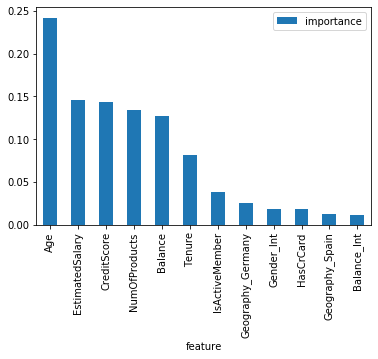

In [43]:
importances.plot.bar();

**Conclusions after visualizing feature importance**

Balance_Int, Geography_Spain, Gender_Int, HasCrCard and Geography_Germany don't play a significant role in our random forest classifier. Therefore, we'll remove them and try the model  again.

We also see that the most important feature is Age.


### RFC withou less important features

#### Redefine X 

In [79]:
# Redefine X 
X = churn_norm[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'EstimatedSalary' ]]

#### Model

In [80]:
RFC_model= RandomForestClassifier()
RFC_model.fit(X_stomek, y_stomek)
RFC_y_pred = RFC_model.predict(X_test)

RFC_score = round(RFC_model.score(X_stomek, y_stomek) * 100, 2)
print(round(RFC_score,2,), "%")

100.0 %


In [81]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, RFC_y_pred))

Accuracy: 0.825


**Evaluation**

Appearenly, we have a lower **accuracy**. So will proceed on checking the **confusion matrix**, which will help us to see how many of a classifier’s predictions were correct and when incorrect.

In [45]:
print(classification_report(y_test, RFC_y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       786
         1.0       0.57      0.53      0.55       214

    accuracy                           0.81      1000
   macro avg       0.72      0.71      0.72      1000
weighted avg       0.81      0.81      0.81      1000



Since the model seems to work a bit low after taking out those columns, we will try it one more time taking out only the last column, as it was the added column from the original dataset.

In [52]:
# Redefine X 
X = churn_norm[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Gender_Int', 'Geography_Germany',
       'Geography_Spain']]

In [53]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [54]:
RFC_model= RandomForestClassifier()
RFC_model.fit(X_train, y_train)
RFC_pred = RFC_model.predict(X_test)

RFC_score = round(RFC_model.score(X_train, y_train) * 100, 2)
print(round(RFC_score,2,), "%")

99.99 %


In [55]:
# Accuracy tells us how often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, RFC_pred))

Accuracy: 0.857


**Conclusions after visualizing feature importance**

The random forest model with less features predicts in general lower than with all features. 

Have an accurancy of 0.82 (vs 0.85 with all features) but a lower recall.

Ususally the more features you have the more likely our model can suffer from overfitting and vice versa. But, in this case we'll prefer to have all features.

In [ ]:
***** ???? 

# RFC_incl_LDA

Check of Random Forest Classification Model adding a column with our LDA variable

In [119]:
churn_norm_lda = pd.read_csv("Churn_norm_LDA.csv")

In [120]:
churn_norm_lda.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Int,Geography_Germany,Geography_Spain,Balance_Int,PC1
0,0.538,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1.0,1.0,0.0,0.0,0.0,-0.244017
1,0.516,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0,1.0,0.0,1.0,1.0,-0.036741
2,0.304,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1.0,1.0,0.0,0.0,1.0,0.868267
3,0.698,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0.0,1.0,0.0,0.0,0.0,0.388012
4,1.000,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0,1.0,0.0,1.0,1.0,-0.021615


In [121]:
# place target column at the end of the dataset
churn_norm_lda= churn_norm_lda[["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard",
                                "IsActiveMember","EstimatedSalary","Gender_Int","Geography_Germany",
                                "Geography_Spain","Balance_Int","PC1","Exited"]]

#### Define X,y

In [122]:
X = churn_norm_lda.iloc[:,:-1]
y = churn_norm_lda['Exited']

#### Split the data into training and testing sets

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1, stratify=y)

#### Model

In [91]:
RFC_model= RandomForestClassifier()

We use **GridSearch** to select the values for a model’s parameters that maximize the accuracy of the model.

In [124]:
params= {
    "n_estimators":[100,300,500],
    # que las clases que me separas sea los mejor posible
    "criterion": ["gini", "entropy"],
    # lo vemos con tree.get_depth() para decidir las combinaciones
    "max_depth": [5, 10]
    
}

RFC_model_sel= GridSearchCV(RFC_model, params)
RFC_model_sel.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=10, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'n_estimators': [100, 300, 500]})

In [125]:
RFC_model_sel.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=300,
                       random_state=42)

In [126]:
RFC_model_sel.best_estimator_.score(X_test, y_test)

0.862

In [127]:
RFC_model_sel.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 300}

#### Define model with its best params

In [128]:
RFC_model=RandomForestClassifier(random_state=42,  
                            n_estimators= 300, 
                            max_depth=10, 
                            criterion='entropy')
RFC_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=300,
                       random_state=42)

**Evaluation**

In [129]:
RFC_y_pred = RFC_model.predict(X_test)
RFC_score = round(RFC_model.score(X_train, y_train) * 100, 2)
print(round(RFC_score,2,), "%")

89.6 %


In [130]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, RFC_y_pred))

Accuracy: 0.862


We see there is less overfitting then before. 

Appearenly, we have a pretty good **accuracy**. But, in thiss case, it is not a great measure of classifier performance, because as seen before, the classes are imbalanced.

We will also proceed on checking the **confusion matrix**, which will help us to see how many of a classifier’s predictions were correct and when incorrect.


In [131]:
print(confusion_matrix(y_test, RFC_y_pred))

[[774  22]
 [116  88]]


True+: 774  False-: 22

False+: 116 True-: 88

Still, we can see that the RF classifier struggled at predicting the clients that didn't churned/exited the bank.

To get even more deeply into model performance and see the what kind of errors the model made, we would do a **Classification report** and check precision, recall and F1 score:

In [132]:
print(classification_report(y_test, RFC_y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       796
         1.0       0.80      0.43      0.56       204

    accuracy                           0.86      1000
   macro avg       0.83      0.70      0.74      1000
weighted avg       0.86      0.86      0.85      1000



We can see that, nothing got better when adding the column lda in our dataset.

Last but not list, we evaluate our training and test data with the **cross validation score**.

In [133]:
scores = cross_val_score(RFC_model, X_train, y_train, cv=StratifiedKFold(), scoring = "accuracy")

In [134]:
print("Scores:", scores, "\n")
print("Mean:", scores.mean(), "\n")
print("Standard Deviation:", scores.std(), "\n")

Scores: [0.86555556 0.86888889 0.85611111 0.86388889 0.86611111] 

Mean: 0.8641111111111112 

Standard Deviation: 0.004311912869318275 



We see our score is as realistic as before. Our model has a average accuracy of 86% with a standard deviation of 0.04 %. The standard deviation shows us, how precise the estimates are. 

As before, the accuracy is still "good" , but we will try to increase it's performance in the following step by reducing imbalance data & removing less important features from our dataset.

## Model RFC+lda reducing imbalance data

Before deciding the right model to do over-samping and/or under-sampling, we visualized the data

- Visualizing original data 

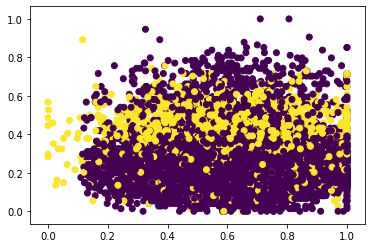

In [135]:
# original data
plt.scatter(X.values[:,0],X.values[:,1], c=y);

- Visualizing data with TSNE

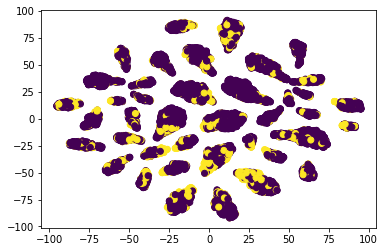

In [136]:
X_red = TSNE().fit_transform(X)
plt.scatter(X_red[:,0],X_red[:,1], c=y);

- Visualizing data with PCA

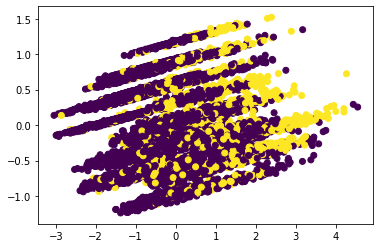

In [137]:
x_pcs = PCA().fit_transform(X)
plt.scatter(x_pcs[:,0], x_pcs[:,1], c=y);

Let's now use a combination of **SMOTE and Tomek Links** to balance our data.

- SMOTE is an oversampling method that synthesizes new plausible examples in the majority class.

- Tomek Links is an undersampling  method that remove unwanted overlap between classes where majority class links are removed until all minimally distanced nearest neighbor pairs are of the same class. 


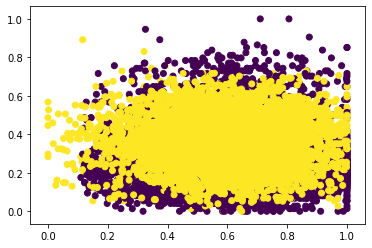

In [138]:
stomek = SMOTETomek ()
X_stomek, y_stomek = stomek.fit_sample(X_train, y_train)
plt.scatter(X_stomek.values[:,0],X_stomek.values[:,1], c=y_stomek);

We use TSNE to visualize few variables after trying to balance our data

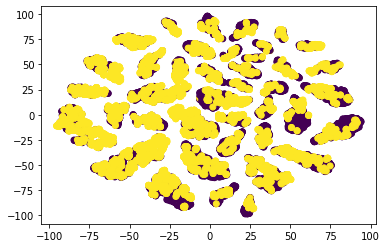

In [139]:
X_red = TSNE().fit_transform(X_stomek)
plt.scatter(X_red[:,0],X_red[:,1], c=y_stomek);

We use TSNE to visualize few variables after trying to balance our data

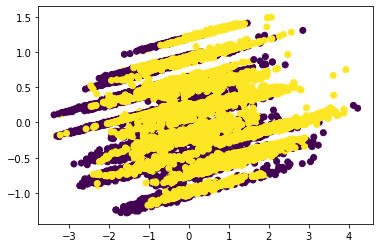

In [140]:
X_pcs = PCA().fit_transform(X_stomek)
plt.scatter(X_pcs[:,0], X_pcs[:,1], c=y_stomek);

Next, we check if the model returns better **results after reducing the imbalance data**:

In [141]:
RFC_model= RandomForestClassifier()
RFC_model.fit(X_stomek, y_stomek)
RFC_y_pred = RFC_model.predict(X_test)

RFC_score = round(RFC_model.score(X_stomek, y_stomek) * 100, 2)
print(round(RFC_score,2,), "%")

100.0 %


In [142]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, RFC_y_pred))

Accuracy: 0.828


**Evaluation**

Appearenly, we have a lower **accuracy**. So will proceed on checking the **confusion matrix**, which will help us to see how many of a classifier’s predictions were correct and when incorrect.

In [143]:
print(classification_report(y_test, RFC_y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       796
         1.0       0.59      0.54      0.56       204

    accuracy                           0.83      1000
   macro avg       0.73      0.72      0.73      1000
weighted avg       0.82      0.83      0.83      1000



We see that the recall is a bit more balance between churn and not churn, As before we had recall of: 
- 0.0-> 0.97
- 0.1-> 0.44

We are interested that Churn (0.1) is higher.

Belowe we evaluate our training and test data with the **cross validation score**.

In [144]:
scores = cross_val_score(RFC_model, X_stomek, y_stomek, cv=StratifiedKFold(), scoring = "accuracy")

In [145]:
print("Scores:", scores, "\n")
print("Mean:", scores.mean(), "\n")
print("Standard Deviation:", scores.std(), "\n")

Scores: [0.83203125 0.90482955 0.92329545 0.93252841 0.92223011] 

Mean: 0.9029829545454545 

Standard Deviation: 0.03658835593330014 



We see our score is better and more realistic when balancing data. Our model has a average accuracy of 90% (vs 0.86%) with a standard deviation of 3%. The standard deviation shows us, how precise the estimates are.

# RFC_Final_Conclusion

Our **Random Forest Mode** performs better (higer recall & less overfitting) after:
- Adding the extra column with the lda
- Reducing inbalanced data

Results are:

In [146]:
print(classification_report(y_test, RFC_y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       796
         1.0       0.59      0.54      0.56       204

    accuracy                           0.83      1000
   macro avg       0.73      0.72      0.73      1000
weighted avg       0.82      0.83      0.83      1000

